<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/bayes_stats/svi_nonlinear_regression_1d_tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# VI for 1d nonlinear regression
# Modified from
# https://colab.sandbox.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb#scrollTo=5zCEYpzu7bDX


In [1]:

# Tensorflow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print("tf version {}".format(tf.__version__))
tf.config.list_physical_devices('GPU')

TensorFlow 2.x selected.
tf version 2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()


import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import os
#figdir = "../figures"
#def save_fig(fname): plt.savefig(os.path.join(figdir, fname))

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

tfd = tfp.distributions


(1200,)


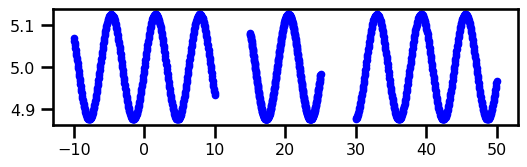

In [39]:

x_range = [-20, 60] # test
x_ranges = [[-20, -10], [0, 20], [40, 50]]
ns = [10, 10, 10]

x_ranges = [ [-10,-5], [15,25], [35,50]]
ns = [400, 400, 400]

def load_dataset():
  w0 = 0.125
  b0 = 5.
  np.random.seed(43)
  def s(x): #std of noise
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = []
  y = []
  for i in range(len(ns)):
    n = ns[i]
    xr = x_ranges[i]
    #x1 = (xr[1] - xr[0]) * np.random.rand(n) + xr[0]
    x1 = np.linspace(xr[0], xr[1], n)
    eps = np.random.randn(n) * s(x1)
    #y1 = (w0 * x1 * (1. + np.sin(x1)) + b0) #+ eps
    #y1 = (w0 * x1  + np.sin(x1) + b0) #+ eps
    y1 = (w0 * np.sin(x1) + b0) #+ eps
    x = np.concatenate((x, x1))
    y = np.concatenate((y, y1))
  print(x.shape)
  x = x[..., np.newaxis]
  n_tst = 150
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()


plt.figure()
plt.plot(x, y, 'b.', label='observed');
plt.show()

In [40]:
# given (n) vector, return (n,2) matrix with x and x^2
def add_squares(x):
  xsq = x ** 2
  return np.stack([x, xsq], axis=1)

#xtrain = add_squares(x[:,0])
#xtest = add_squares(x_tst[:,0])

xtrain = x
xtest = x_tst
print(xtrain.shape)


(1200, 1)


In [0]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


"""### Case 1: No Uncertainty"""
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(200),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(xtrain, y, epochs=1000, verbose=False);
yhat = model(xtest)
assert isinstance(yhat, tfd.Distribution)




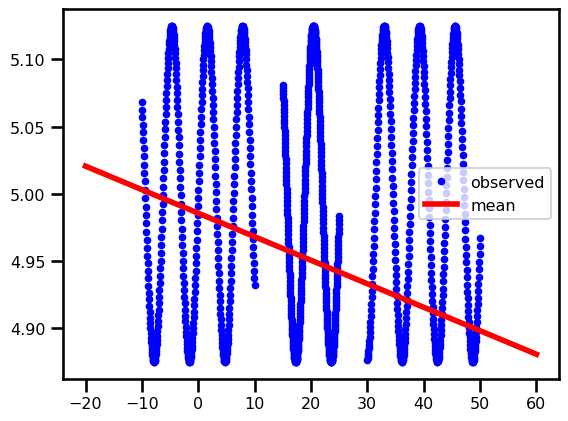

In [42]:

plt.figure()
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.legend()
#save_fig('svi_nonlin_regression_1d_mean.pdf')
plt.show()

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  15        
_________________________________________________________________
dense_7 (Dense)              multiple                  30        
_________________________________________________________________
dense_8 (Dense)              multiple                  6         
_________________________________________________________________
distribution_lambda_3 (Distr multiple                  0         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


[0.12822583 0.9945984 ]
[ 5.203962  13.3055315]


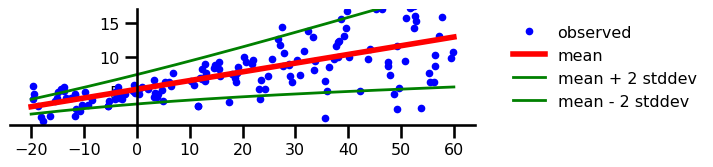

In [0]:
"""### Case 2: Aleatoric Uncertainty"""

# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

#@title Figure 2: Aleatoric Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

#plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)
#save_fig('svi_regression_1d_mean_var.pdf')
plt.show()



[ 0.13895793  5.134777   -4.023219   -2.2406175 ]
[0.13411504 5.1226187 ]


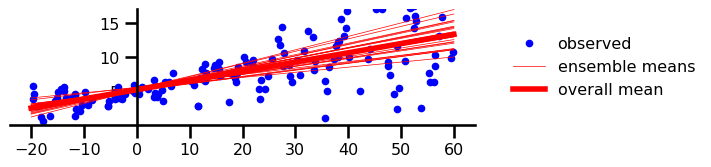

In [0]:
"""### Case 3: Epistemic Uncertainty"""

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

#@title Figure 3: Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

#plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)
#save_fig('svi_regression_1d_post_mean.pdf')
plt.show()


[ 0.13936323  2.9325755   5.1828575   4.2519164  -3.5649672  -0.96170765
 -2.2866282  -0.01334832]
[0.13931762 2.8068864  5.199069   4.1721373 ]


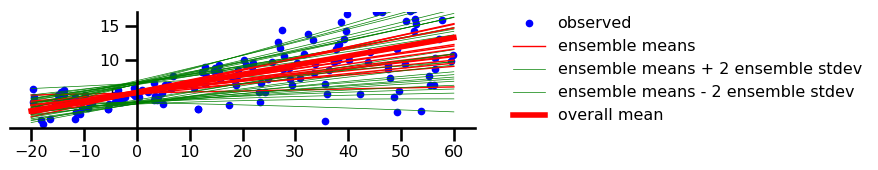

In [0]:
#Both Aleatoric & Epistemic Uncertainty

# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

#plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)
#save_fig('svi_regression_1d_post_mean_var.pdf')
plt.show()